In [1]:
# Zelle 0: Installieren von Bibliotheken (falls noch nicht vorhanden)
!pip install lightgbm opencv-python-headless numpy scikit-learn matplotlib

In [2]:
# Zelle 1: Importieren der notwendigen Bibliotheken
import cv2
import os
import glob
import numpy as np
from PIL import Image
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
# Zelle 2: Bilder in Segmente teilen für Single Character
def split_captcha_images(folder_path):
    # Überprüfen, ob der Ordner existiert
    if not os.path.exists(folder_path):
        print(f"Der Ordner {folder_path} existiert nicht.")
        return

    # Erstellen eines Ausgabeordners
    output_folder = os.path.join("captchas/train_split_images")
    os.makedirs(output_folder, exist_ok=True)

    # Iterieren durch alle Bilder im Ordner
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Überprüfen auf Bilddateien
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)

            # Bestimmen der Breite und Höhe des Bildes
            width, height = image.size
            
            # Berechnen der Breite für die Teile
            part_width = width // 5
            
            # Vertikal aufteilen und speichern
            for i in range(5):
                left = i * part_width
                right = left + part_width if i < 4 else width  # Letztes Bild bis zum Ende
                bbox = (left, 0, right, height)
                
                # Ausschneiden des Bildes
                cropped_image = image.crop(bbox)
                
                # Den entsprechenden Buchstaben aus dem ursprünglichen Dateinamen abrufen
                # Ignoriere die Dateiendung
                original_char = filename.split('.')[0][i]
                
                # Speichern des Bildes mit dem angehängten Buchstaben
                cropped_image.save(os.path.join(output_folder, f"{filename}_part_{i + 1}_{original_char}.png"))

            print(f"{filename} wurde in 5 Teile aufgeteilt und gespeichert.")

# Beispiel für die Verwendung der Funktion
folder_path = "captchas/train"  # Ersetzen Sie dies durch Ihren Ordnerpfad
split_captcha_images(folder_path)


004z1.jpg wurde in 5 Teile aufgeteilt und gespeichert.
00rAU.jpg wurde in 5 Teile aufgeteilt und gespeichert.
00S80.jpg wurde in 5 Teile aufgeteilt und gespeichert.
00TGg.jpg wurde in 5 Teile aufgeteilt und gespeichert.
00XLd.jpg wurde in 5 Teile aufgeteilt und gespeichert.
01DLV.jpg wurde in 5 Teile aufgeteilt und gespeichert.
01j9c.jpg wurde in 5 Teile aufgeteilt und gespeichert.
01KCi.jpg wurde in 5 Teile aufgeteilt und gespeichert.
01yGg.jpg wurde in 5 Teile aufgeteilt und gespeichert.
02DzO.jpg wurde in 5 Teile aufgeteilt und gespeichert.
02MDB.jpg wurde in 5 Teile aufgeteilt und gespeichert.
02rDr.jpg wurde in 5 Teile aufgeteilt und gespeichert.
02UYR.jpg wurde in 5 Teile aufgeteilt und gespeichert.
02VXh.jpg wurde in 5 Teile aufgeteilt und gespeichert.
032DX.jpg wurde in 5 Teile aufgeteilt und gespeichert.
03ExZ.jpg wurde in 5 Teile aufgeteilt und gespeichert.
03RRz.jpg wurde in 5 Teile aufgeteilt und gespeichert.
03uFk.jpg wurde in 5 Teile aufgeteilt und gespeichert.
03Y9E.jpg 

In [4]:
# Zelle 3: Dateien im Ordner durchgehen und Bildpfade sowie Labels hinzufügen
image_paths= []
labels = []
folder_path = "captchas/train_split_images"
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):  # Nur PNG-Bilder auswählen
        image_paths.append(os.path.join(folder_path, filename))
        labels.append(filename[-5])  # Letztes Zeichen des Dateinamens (vor der Dateiendung) als Label verwenden

# Ausgabe zur Kontrolle
print("Bildpfade:", image_paths)
print("Labels:", labels)


Bildpfade: ['captchas/train_split_images\\004z1.jpg_part_1_0.png', 'captchas/train_split_images\\004z1.jpg_part_2_0.png', 'captchas/train_split_images\\004z1.jpg_part_3_4.png', 'captchas/train_split_images\\004z1.jpg_part_4_z.png', 'captchas/train_split_images\\004z1.jpg_part_5_1.png', 'captchas/train_split_images\\00rAU.jpg_part_1_0.png', 'captchas/train_split_images\\00rAU.jpg_part_2_0.png', 'captchas/train_split_images\\00rAU.jpg_part_3_r.png', 'captchas/train_split_images\\00rAU.jpg_part_4_A.png', 'captchas/train_split_images\\00rAU.jpg_part_5_U.png', 'captchas/train_split_images\\00S80.jpg_part_1_0.png', 'captchas/train_split_images\\00S80.jpg_part_2_0.png', 'captchas/train_split_images\\00S80.jpg_part_3_S.png', 'captchas/train_split_images\\00S80.jpg_part_4_8.png', 'captchas/train_split_images\\00S80.jpg_part_5_0.png', 'captchas/train_split_images\\00TGg.jpg_part_1_0.png', 'captchas/train_split_images\\00TGg.jpg_part_2_0.png', 'captchas/train_split_images\\00TGg.jpg_part_3_T.png'

In [5]:
# Zelle 4: Funktion zum Vorverarbeiten der Bilder
def preprocess_image(image_path, target_size=(50, 50)):  # Schließende Klammer hinzugefügt
    # Lade das Bild in Graustufen
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Bild konnte nicht geladen werden: {image_path}")

    # Berechne das Seitenverhältnis
    h, w = image.shape
    aspect_ratio = w / h

    # Berechne neue Dimensionen unter Beibehaltung des Seitenverhältnisses
    if aspect_ratio > 1:  # Bild ist breiter
        new_w = target_size[0]
        new_h = int(new_w / aspect_ratio)
    else:  # Bild ist höher oder quadratisch
        new_h = target_size[1]
        new_w = int(new_h * aspect_ratio)

    # Bild auf die neue Größe ändern
    image = cv2.resize(image, (new_w, new_h))

    # Erstelle ein weißes Bild mit den Zielmaßen
    new_image = np.ones((target_size[1], target_size[0]), dtype=np.uint8) * 255  # Weiße Farbe

    # Berechne die Position, um das Bild in der Mitte zu platzieren
    y_offset = (target_size[1] - new_h) // 2
    x_offset = (target_size[0] - new_w) // 2

    # Füge das Bild in das neue Bild ein
    new_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = image

    # Überprüfe den Wert des Bildes vor der Normalisierung
    if np.sum(new_image) == 0:
        print(f"Warnung: Bild leer nach der Verarbeitung: {image_path}")

    # In einen eindimensionalen Array umwandeln (Feature-Vektor)
    return new_image.flatten() / 255.0  # Normalisierung der Pixelwerte

In [6]:
# Zelle 5: Funktion zum Vorverarbeiten der Bilder
def preprocess_image(image_path, target_size=(50, 50)):  # Schließende Klammer hinzugefügt
    # Lade das Bild in Graustufen
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Bild konnte nicht geladen werden: {image_path}")

    # Berechne das Seitenverhältnis
    h, w = image.shape
    aspect_ratio = w / h

    # Berechne neue Dimensionen unter Beibehaltung des Seitenverhältnisses
    if aspect_ratio > 1:  # Bild ist breiter
        new_w = target_size[0]
        new_h = int(new_w / aspect_ratio)
    else:  # Bild ist höher oder quadratisch
        new_h = target_size[1]
        new_w = int(new_h * aspect_ratio)

    # Bild auf die neue Größe ändern
    image = cv2.resize(image, (new_w, new_h))

    # Erstelle ein weißes Bild mit den Zielmaßen
    new_image = np.ones((target_size[1], target_size[0]), dtype=np.uint8) * 255  # Weiße Farbe

    # Berechne die Position, um das Bild in der Mitte zu platzieren
    y_offset = (target_size[1] - new_h) // 2
    x_offset = (target_size[0] - new_w) // 2

    # Füge das Bild in das neue Bild ein
    new_image[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = image

    # Überprüfe den Wert des Bildes vor der Normalisierung
    if np.sum(new_image) == 0:
        print(f"Warnung: Bild leer nach der Verarbeitung: {image_path}")

    # In einen eindimensionalen Array umwandeln (Feature-Vektor)
    return new_image.flatten() / 255.0  # Normalisierung der Pixelwerte

In [7]:
# Zelle 6: Vorverarbeite die Bilder
X = np.array([preprocess_image(path, target_size=(50, 50)) for path in image_paths])
y = np.array(labels)

Erstes Label: 0

Erstes Element von X komprimiert dargestellt:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


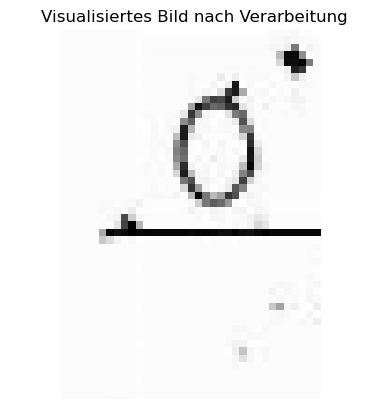

In [8]:
# Zelle 7: Ausgabe des ersten Labels und X
print("Erstes Label:", y[0])

print("\nErstes Element von X komprimiert dargestellt:")
print(X[0].reshape(50, 50)) 

#Visualisiere das erste Bild nach der Verarbeitung
plt.imshow(X[0].reshape(50, 50), cmap='gray')
plt.title("Visualisiertes Bild nach Verarbeitung")
plt.axis('off')
plt.show()

In [9]:
# Zelle 8: Dimension von X überprüfen
print("Dimensionen von X:", X.shape)

Dimensionen von X: (32690, 2500)


In [10]:
#Zelle 9:
from sklearn.preprocessing import LabelEncoder

# Ursprüngliche Labels in numerische Klassen umwandeln
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
# Zelle 10: Trainings- und Testdatenaufteilung
# Trainings- und Testdatenaufteilung
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print("Trainingsdatensatzgröße:", X_train.shape)
print("Testdatensatzgröße:", X_test.shape)

Trainingsdatensatzgröße: (26152, 2500)
Testdatensatzgröße: (6538, 2500)


In [12]:
# Zelle 11: Modelltraining mit LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y_encoded)),
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,  # Weniger Blätter
    "learning_rate": 0.1,  # Anpassung der Lernrate
    "min_data_in_leaf": 20,  # Mindestanzahl an Daten in einem Blatt
    "verbose": -1,
    "force_col_wise": True
}

model = lgb.train(params, train_data, num_boost_round=100)

In [13]:
# Zelle 13: Modellvorhersagen und Bewertung
y_pred = model.predict(X_test)
y_pred_labels = [np.argmax(pred) for pred in y_pred]

# Ausgabe der Modell-Genauigkeit
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")



Model Accuracy: 7.19%


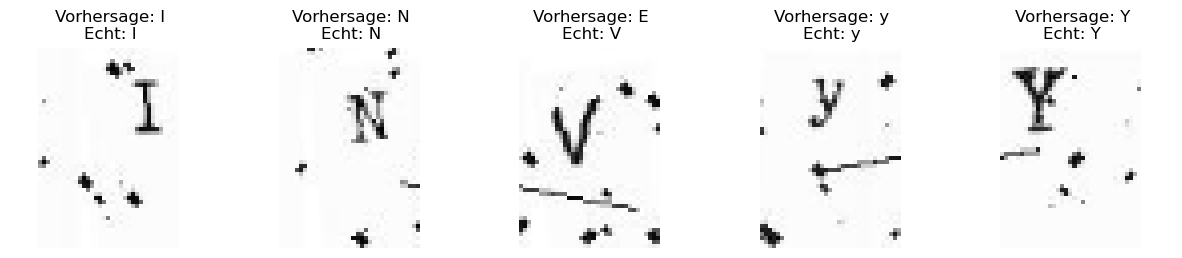

In [14]:
# Zelle 13: Vorhersagen visualisieren
def visualize_predictions(model, image_paths, true_labels, num_samples=5):
    # Auswahl der letzten Indizes für die Visualisierung
    indices = np.arange(len(image_paths) - num_samples, len(image_paths))
    
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        # Bildvorbereitung
        image = preprocess_image(image_paths[idx])  # Bild vorverarbeiten
        prediction = model.predict(np.expand_dims(image, axis=0))  # Vorhersage
        predicted_label_index = np.argmax(prediction)  # Index mit der höchsten Wahrscheinlichkeit
        predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]  # Numerisches Label in Zeichen umwandeln
        
        # Anzeige des Bildes und der Labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.reshape(50, 50), cmap='gray')
        plt.title(f"Vorhersage: {predicted_label}\nEcht: {true_labels[idx]}")
        plt.axis('off')
    
    plt.show()

# Aufruf der Funktion zur Visualisierung der letzten fünf Vorhersagen
visualize_predictions(model, image_paths, labels, num_samples=5)
